In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_data_template
from src.features.games import GameFeatures

In [3]:
game_feat = GameFeatures(default_lags=3)
data = load_data_template()
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_season, fillna=0)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_tourney, fillna=0)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_season_against_opponent, fillna=0, per_game=True)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_tourney_against_opponent, fillna=0, per_game=True)
data.dropna(inplace=True)
data.sample()

,Season,team_a,team_b,in_target,game_set,a_win,DayNum,games_won_in_season_team_a,games_won_in_season_team_a_lag-1,games_won_in_season_team_a_lag-2,...,games_won_in_season_against_opponent_team_b,games_won_in_season_against_opponent_team_b_lag-1,games_won_in_season_against_opponent_team_b_lag-2,games_won_in_season_against_opponent_team_b_lag-3,games_won_in_tourney_against_opponent_team_a_lag-1,games_won_in_tourney_against_opponent_team_a_lag-2,games_won_in_tourney_against_opponent_team_a_lag-3,games_won_in_tourney_against_opponent_team_b_lag-1,games_won_in_tourney_against_opponent_team_b_lag-2,games_won_in_tourney_against_opponent_team_b_lag-3
10178,2001,1268,1390,False,0,True,145,21,24.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss


X = data.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target', 'DayNum'], axis=1)
y = data[['a_win']].astype(int)

kf = KFold(n_splits=15, shuffle=True)
metrics = []
for tr_i, t_i in kf.split(X):
    X_tr, y_tr = X.iloc[tr_i], y.iloc[tr_i]
    X_t, y_t = X.iloc[t_i], y.iloc[t_i]
    xgb = XGBClassifier()
    xgb.fit(X_tr.values, y_tr.values.reshape(-1))
    preds = xgb.predict_proba(X_t.values)
    metric = log_loss(y_t.values, preds)
    print(metric)
    metrics.append(metric)
    
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

0.4215546352165738
0.3967926525346882
0.3531487877876993
0.4350626844952398
0.4392965793186891
0.41405776576039954
0.32933683118763124
0.38370086334923165
0.363343875435782
0.3271596952348102
0.3820927279129466
0.35965174930962795
0.33455572361853103
0.39085492067012595
0.2778038609416244
Metric Mean: 0.37 (0.04)


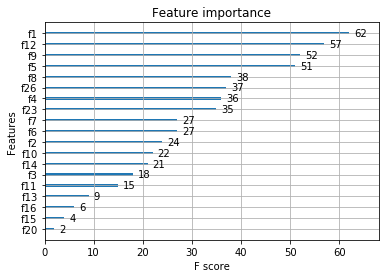

In [5]:
from xgboost import plot_importance

plt.figure(figsize=(20,8))
plot_importance(xgb, max_num_features=20)
plt.show()